# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None].T
Y = XY[:, 1, None]

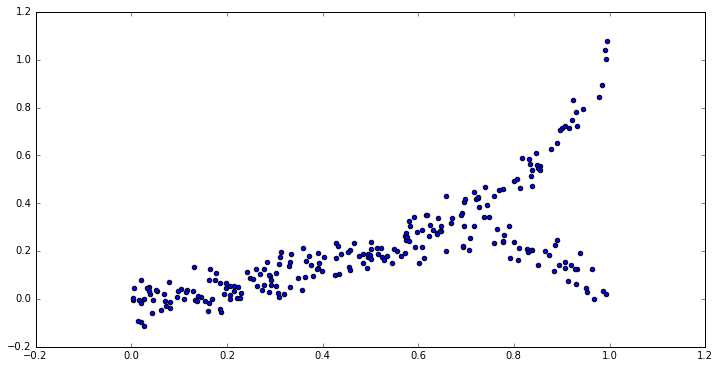

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, variance=0.01, prior_Z='DP')
m.log_likelihood()

1151.607899906686

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

In [5]:
XX = np.linspace(X.min(), X.max())[:, None]


In [6]:
mu, va = m.predict_components(XX)


InvalidArgumentError: Input matrix and rhs are incompatible.
	 [[Node: MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Cholesky, Diag_2)]]
Caused by op u'MatrixTriangularSolve', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-34fc78554db5>", line 1, in <module>
    mu, va = m.predict_components(XX)
  File "/Users/danmarthaler/GPflow/GPflow/param.py", line 515, in runnable
    storage['tf_result'] = tf_method(instance, *storage['tf_args'])
  File "/Users/danmarthaler/GPclust/GPclust/OMGP.py", line 99, in predict_components
    mu, va = self.predict(Xnew, i)
  File "/Users/danmarthaler/GPclust/GPclust/OMGP.py", line 82, in predict
    K_B_inv = tf.matrix_triangular_solve(LB, GPflow.tf_wraps.eye(self.D), lower=True)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 495, in matrix_triangular_solve
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


IndexError: too many indices for array

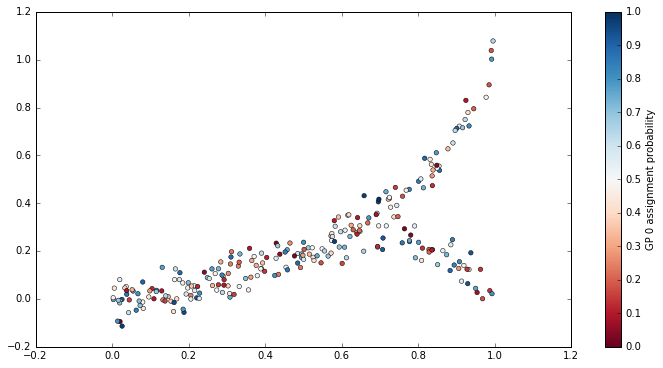

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

In [6]:
debug

> /Users/james/anaconda/envs/py35-tf10/lib/python3.5/site-packages/tensorflow/python/util/compat.py(45)as_bytes()
     43   else:
     44     raise TypeError('Expected binary or unicode string, got %r' %
---> 45                     (bytes_or_text,))
     46 
     47 

ipdb> q


There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

In [7]:
from plotter import OMGPplot_probs
OMGPplot_probs(model, X, gp_num=0)

NameError: name 'model' is not defined

We can first performa a quick optimization to find the rough trends.

In [8]:
m.optimize(step_length=0.01, maxiter=20)

iteration 1 bound=1137.98815773 grad=448.726797609, beta=0
iteration 2 bound=1146.58167378 grad=412.173586229, beta=1.00533788492
iteration 3 bound=1158.60333818 grad=354.304357902, beta=1.00376706276
iteration 4 bound=1172.89231706 grad=288.148950571, beta=0.987846672796
iteration 5 bound=1187.5763521 grad=221.007197226, beta=0.951914910262
iteration 6 bound=1200.42305229 grad=158.567498419, beta=0.897084883656
iteration 7 bound=1209.99617388 grad=106.756045585, beta=0.834535446859
iteration 8 bound=1216.2519791 grad=69.1260707824, beta=0.77848044486
iteration 9 bound=1219.99260414 grad=44.8890029326, beta=0.735397143846
iteration 10 bound=1222.14115022 grad=30.5975973465, beta=0.704979119819
iteration 11 bound=1223.4000214 grad=22.5156684462, beta=0.69034571012
iteration 12 bound=1224.20437374 grad=17.8317561476, beta=0.700687119316
iteration 13 bound=1224.7866144 grad=14.8370737471, beta=0.73659069367
iteration 14 bound=1225.25702481 grad=12.6475379854, beta=0.78022653604
iteration 

TypeError: Expected binary or unicode string, got <GPflow.param.DataHolder object at 0x11e5803c8>

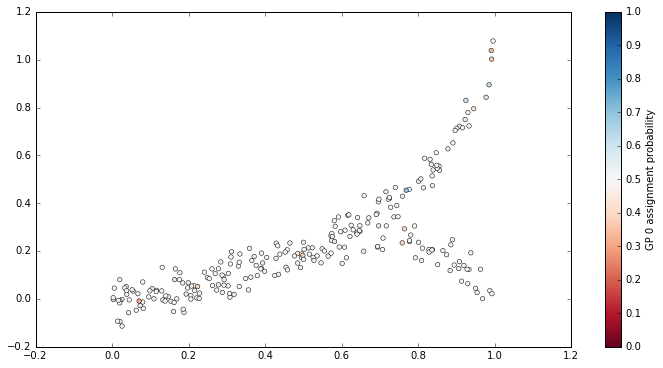

In [9]:
OMGPplot(m,X,Y)

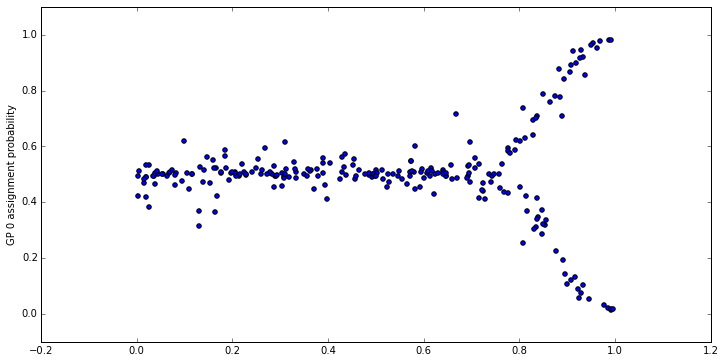

In [15]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [16]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.01,+ve,,
rbf_1.variance,1.0,+ve,,
rbf_1.lengthscale,1.0,+ve,,
rbf.variance,1.0,+ve,,
rbf.lengthscale,1.0,+ve,,


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [17]:
m.optimize(step_length=0.01, maxiter=200)

iteration 200 bound=1588.80940759 grad=197.3883808, beta=0.0 maxiter exceeded


 :0: FutureWarning:IPython widgets are experimental and may change in the future.


In [18]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.0014606243382,+ve,,
rbf_1.variance,1.02213521375,+ve,,
rbf_1.lengthscale,0.595341949099,+ve,,
rbf.variance,1.16851232834,+ve,,
rbf.lengthscale,0.448887117217,+ve,,


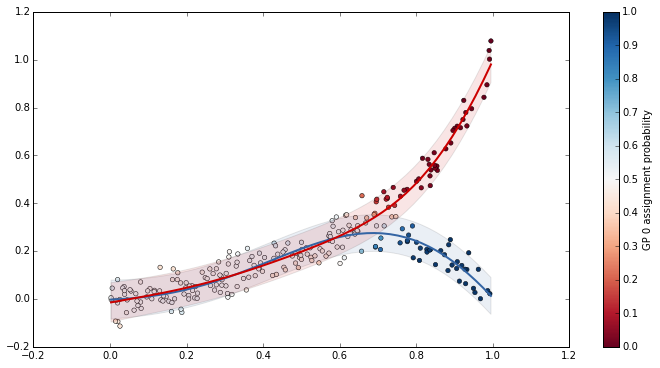

In [19]:
OMGPplot(m,X,Y)

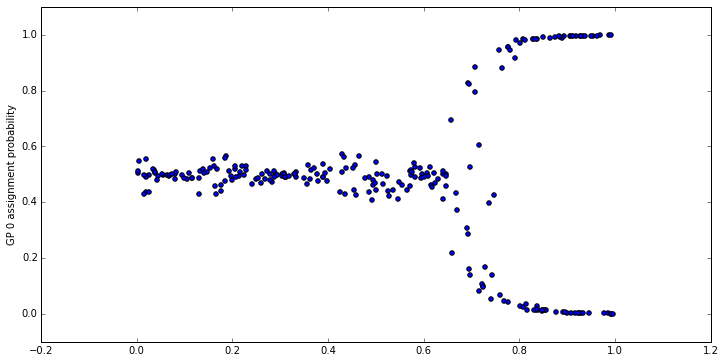

In [20]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [21]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

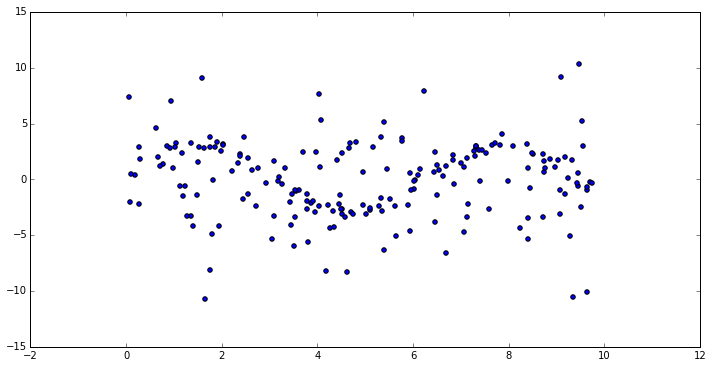

In [23]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [24]:
kernels = [GPy.kern.RBF(1)]
m = OMGP(x, y, K=1, prior_Z='DP', kernels=kernels)
m.variance = 3
m.hyperparam_interval = 100
m.rbf.lengthscale = 2

In [25]:
m.optimize(verbose=False)

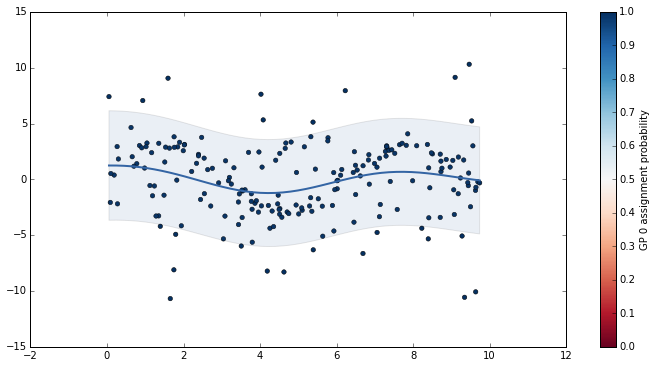

In [27]:
OMGPplot(m,x)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [28]:
kernels = [GPy.kern.White(1, name='Noise'), GPy.kern.RBF(1, name='Signal')]
m = OMGP(x, y, K=2, prior_Z='DP', kernels=kernels)
m.variance = 3
m.hyperparam_interval = 250
m.Signal.lengthscale = 2

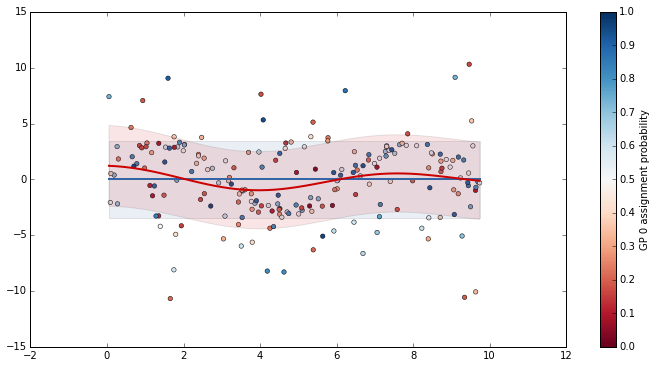

In [29]:
OMGPplot(m,x)

In [30]:
m.optimize(step_length=0.01, verbose=False)

In [31]:
m

OMGP.,Value,Constraint,Prior,Tied to
variance,0.322524350505,+ve,,
Noise.variance,8.84138047261,+ve,,
Signal.variance,3.02502159938,+ve,,
Signal.lengthscale,1.50887475231,+ve,,


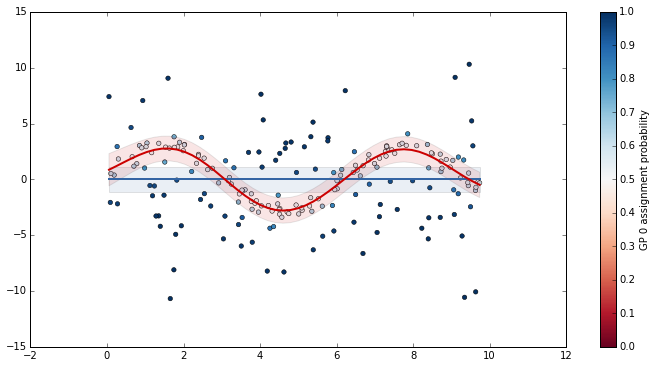

In [32]:
OMGPplot(m,x)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

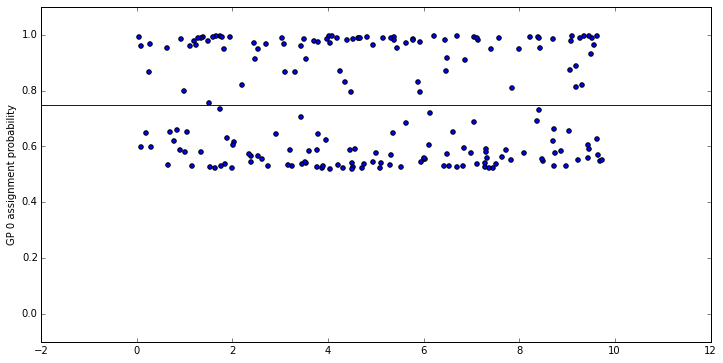

In [34]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [36]:
thr = 0.75
idx = np.where(m.phi[:,0] < thr)[0]
nidx = np.where(m.phi[:,0] >= thr)[0]

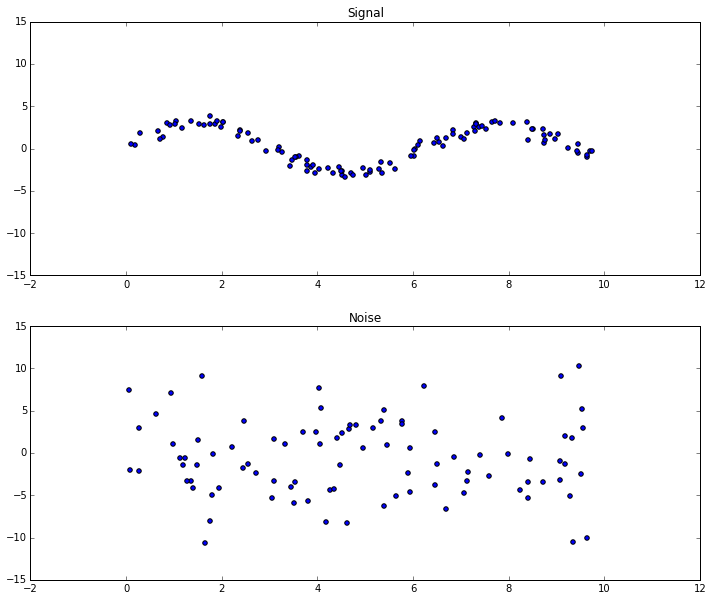

In [37]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');